# Tarea 2
## Profesor: Dr. Esteban Vargas; Alumno: Enrique Reyes
### 10/12/2020

El conjunto de datos a análizar contiene información sobre los reportes de contagios, recuperados y muertes diarias de SARS-CoV-2 Covid-19, de Uruguay (13 de marzo de 2020 al 04 de enero de 2021), Nigeria (20 de marzo a 29 de junio de 2020) y Filipinas (06 de marzo a 15 de junio de 2020).

## 1. Carga de paquetes y datos

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [2]:
import PDEparams as pde

In [3]:
# Cargamos los datos
URU = pd.read_csv("Uruguay_SCC-19.csv")
# Visualizamos los primeros elementos de la base de datos de Mexico
URU.head()

,t,I,R,D
0,0,4,0,0
1,1,2,0,0
2,2,2,0,0
3,3,21,0,0
4,4,21,0,0


In [4]:
NIG=pd.read_csv("Nigeria_SCC-19.csv")
# Visualizamos los primeros elementos de la base de datos de Mexico
NIG.head()

,t,I,R,M
0,0,4,0,0
1,1,10,0,0
2,2,8,1,0
3,3,10,0,1
4,4,4,0,0


In [5]:
FIL=pd.read_csv("Filipinas_SCC-19.csv")
# Visualizamos los primeros elementos de la base de datos de Mexico
FIL.head()

,t,I,R,D
0,0,2,0,0
1,1,1,0,0
2,2,4,0,0
3,3,10,0,0
4,4,13,1,0


## 2. Análsis Exploratorio de Datos

Text(0.5, 1.0, 'Muertes')

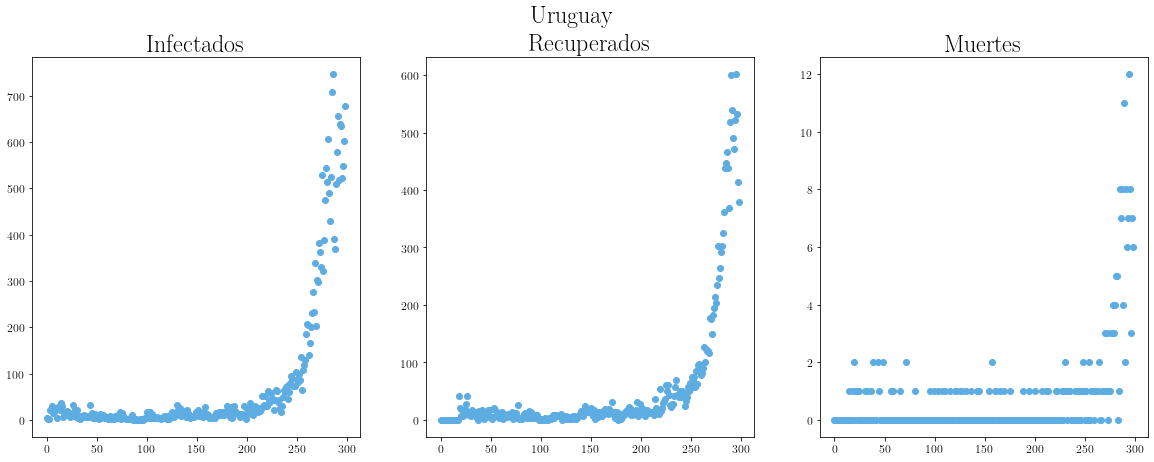

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7))
fig.suptitle('Uruguay')
fig.figsize=(15,15)
ax1.plot(URU.I, 'o',color="#5DADE2")
ax1.set_title('Infectados')
ax2.plot(URU.R, 'o',color="#5DADE2")
ax2.set_title('Recuperados')
ax3.plot(URU.D, 'o',color="#5DADE2")
ax3.set_title('Muertes')

In [7]:
URU.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,299.0,149.000000,86.458082,0.0,74.5,149.0,223.5,298.0
I,299.0,74.066890,152.851407,0.0,6.0,14.0,38.0,747.0
R,299.0,53.244147,114.364236,0.0,5.5,12.0,31.5,602.0
D,299.0,0.725753,1.684425,0.0,0.0,0.0,1.0,12.0


Text(0.5, 1.0, 'Muertes')

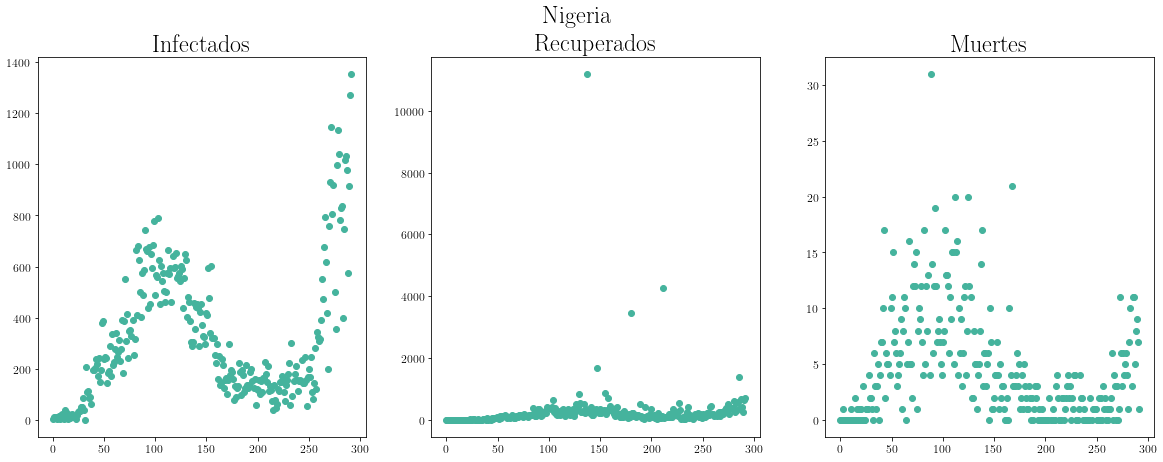

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7))
fig.suptitle('Nigeria')
ax1.plot(NIG.I, 'o',color="#45B39D")
ax1.set_title('Infectados')
ax2.plot(NIG.R, 'o',color="#45B39D")
ax2.set_title('Recuperados')
ax3.plot(NIG.M, 'o',color="#45B39D")
ax3.set_title('Muertes')

In [9]:
NIG.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,292.0,145.500000,84.437354,0.0,72.75,145.5,218.25,291.0
I,292.0,317.455479,259.951360,0.0,132.75,237.0,462.25,1354.0
R,292.0,261.626712,735.731145,0.0,80.25,159.5,277.00,11188.0
M,292.0,4.523973,4.928643,0.0,1.00,3.0,7.00,31.0


Text(0.5, 1.0, 'Muertes')

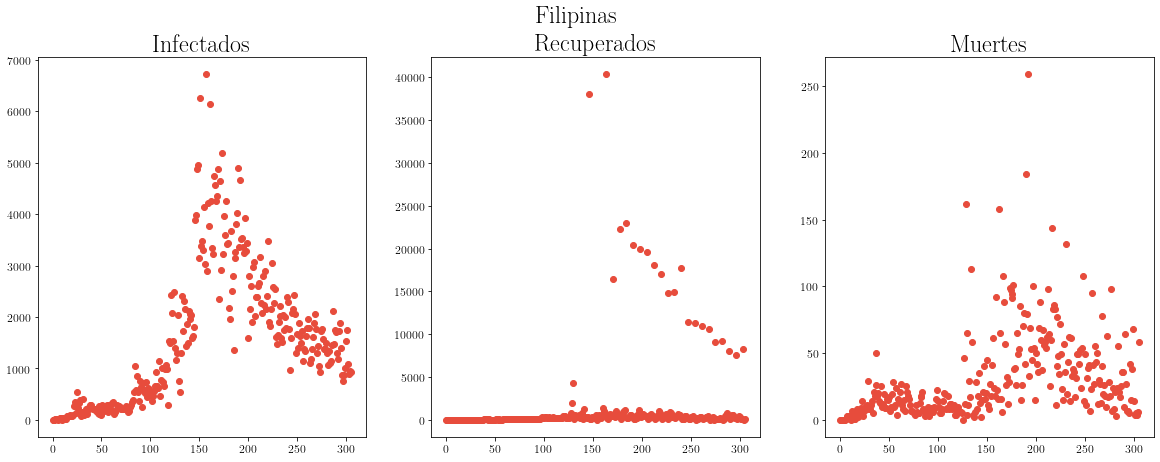

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7))
fig.suptitle('Filipinas')
ax1.plot(FIL.I, 'o',color="#E74C3C")
ax1.set_title('Infectados')
ax2.plot(FIL.R, 'o',color="#E74C3C")
ax2.set_title('Recuperados')
ax3.plot(FIL.D, 'o',color="#E74C3C")
ax3.set_title('Muertes')

In [11]:
FIL.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,306.0,152.500000,88.478811,0.0,76.25,152.5,228.75,305.0
I,306.0,1567.614379,1354.937727,1.0,320.50,1384.0,2226.25,6725.0
R,306.0,1466.686275,4858.535099,0.0,82.00,226.5,469.25,40377.0
D,306.0,30.470588,33.260139,0.0,8.00,18.0,42.00,259.0


## 3. Modelos de ecuaciones diferenciales
### 3.1 SIR

<style>
p.comment {
background-color: #DBDBDB;
padding: 10px;
border: 1px solid black;
margin-left: 25px;
border-radius: 5px;
font-style: italic;
}
</style>

Es un modelo de ecuaciones diferenciales utilizado en epidemiología para modelar el compotamiento de enfermedades infecciosas, fue diseñado en 1927 por los médicos W. O. Kermack y A. G. McKendrick. Cuando una enfermedad es nueva como el **SARS-CoV 2 (Covid 19)** todos los habitantes de una población son candidatos a contraer dicha enfermedad con la misma probabilidad, con forme avanza el brote infeccioso diferentes condiciones hacen que aumente o disminuya la probabilidad de ser contagiado.
<p></p>
Un supuesto que se hace en este modelo es pensar en una población cerrada ante nacimientos y migración, por lo tanto la población inicial

<div class="alert alert-info">
    <ul>
      <li><strong>Susceptibles:</strong> personas que pueden contraer la enfermedad.</li>
      <li><strong>Infectados:</strong> personas que contrajeron la enfermedad y pueden contagiar a los demás.</li>
      <li><strong>Recuperados:</strong> personas que salieron de la enfermedad y adquieren inmunidad temporal.</li>
    </ul>
</div>


$$
\begin{eqnarray}
\frac{dS}{dt}&=& -\beta S\frac{I}{N} \\
\frac{dI}{dt}&=& \beta S\frac{I}{N} - \gamma I \\
\frac{dR}{dt}&=& \gamma I
\end{eqnarray}
$$


In [12]:
# Modelo
def SIR(z, t, beta, gamma):
    
    S, I, R= z
    
    return [-beta*(S/N)*I,beta*(S/N)*I-gamma*I,gamma*I]

In [13]:
N=3449299
def SURU():   
    return N-4     # I_0
def IURU():   
    return 4     # I_0
def RURU():
    return 0       # R_0
URU1=URU.loc[:,["t","I","R"]]
#URU1=URU1[0:100]

In [14]:
modeloURU = pde.PDEmodel(URU1, SIR, [SURU,IURU,RURU], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [15]:
# Printing the initial condition
modeloURU.initial_condition

array([3449295,       4,       0])

In [16]:
%%time
modeloURU.fit()

    $\beta$  $\gamma$
0  0.027434  0.011225
Wall time: 1.45 s


In [17]:
modeloURU.best_params

,$\beta$,$\gamma$
0,0.027434,0.011225


In [18]:
modeloURU.best_error

4680.044775115135

In [19]:
%%time
modeloURU.likelihood_profiles()



Wall time: 1min 34s


In [20]:
modeloURU.result_profiles

,parameter,value,error
0,$\beta$,0.000000,22108.771797
1,$\beta$,0.010101,21844.702067
2,$\beta$,0.020202,7207.616633
3,$\beta$,0.030303,5018.983152
4,$\beta$,0.040404,8925.119043
...,...,...,...
195,$\gamma$,0.959596,20794.275902
196,$\gamma$,0.969697,20795.420917
197,$\gamma$,0.979798,20796.616931
198,$\gamma$,0.989899,20797.702921


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


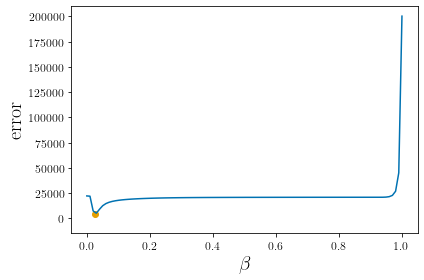

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


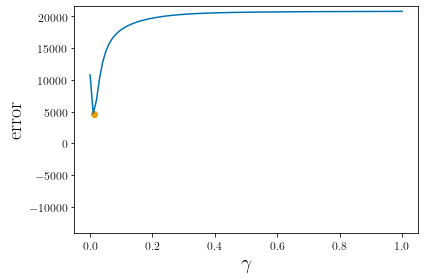

In [21]:
modeloURU.plot_profiles()

In [22]:
# Tomamos los valores del modelo
beta = modeloURU.best_params.iloc[0,0]
gamma = modeloURU.best_params.iloc[0,1]
z0 = modeloURU.initial_condition
# Integrate the SIR equations over the time grid, t.
t = URU.t
ret = odeint(SIR, z0, t, args=(beta, gamma))
S, I, R = ret.T

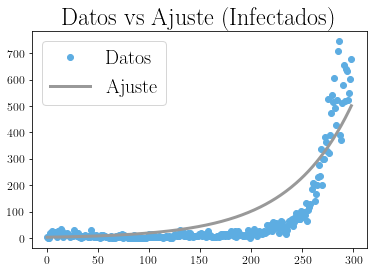

In [23]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Infectados)")
plt.plot(t,URU.I,'o',label="Datos",color="#5DADE2")
plt.plot(t,I,'-',lw=3,label="Ajuste")
plt.legend()

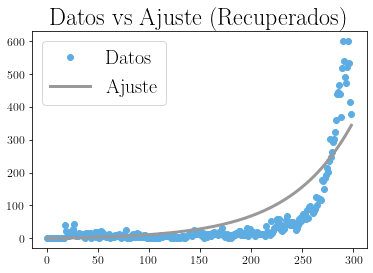

In [24]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Recuperados)")
plt.plot(t,URU.R,'o',label="Datos",color="#5DADE2")
plt.plot(t,R,'-',lw=3,label="Ajuste")
plt.legend()

In [25]:
N=195874740
def SNIG():   
    return N-4     # I_0
def INIG():   
    return 4     # I_0
def RNIG():
    return 0       # R_0
NIG1=NIG.loc[:,["t","I","R"]]
NIG1=NIG1[0:100]

In [26]:
modeloNIG = pde.PDEmodel(NIG1, SIR, [SNIG,INIG,RNIG], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [27]:
# Printing the initial condition
modeloNIG.initial_condition

array([195874736,         4,         0])

In [28]:
%%time
modeloNIG.fit()

    $\beta$  $\gamma$
0  0.078274  0.023412
Wall time: 897 ms


In [29]:
modeloNIG.best_params

,$\beta$,$\gamma$
0,0.078274,0.023412


In [30]:
modeloNIG.best_error

10303.765907030791

In [31]:
%%time
modeloNIG.likelihood_profiles()



Wall time: 1min 11s


In [32]:
modeloNIG.result_profiles

,parameter,value,error
0,$\beta$,0.000000,60024.493488
1,$\beta$,0.010101,60292.482001
2,$\beta$,0.020202,59744.385009
3,$\beta$,0.030303,51159.815044
4,$\beta$,0.040404,39917.984806
...,...,...,...
195,$\gamma$,0.959596,54848.443911
196,$\gamma$,0.969697,54874.902948
197,$\gamma$,0.979798,54900.926891
198,$\gamma$,0.989899,54926.530705


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


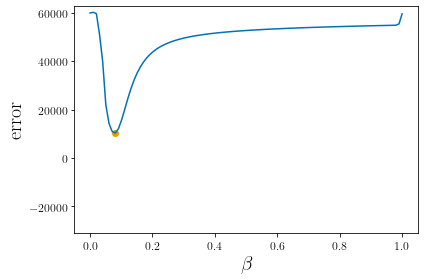

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


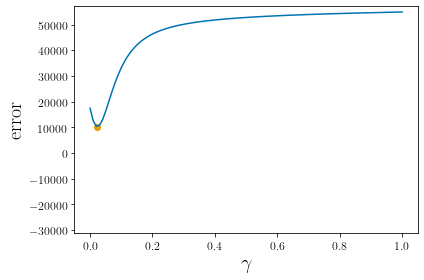

In [33]:
modeloNIG.plot_profiles()

In [34]:
# Tomamos los valores del modelo
beta = modeloNIG.best_params.iloc[0,0]
gamma = modeloNIG.best_params.iloc[0,1]
z0 = modeloNIG.initial_condition
# Integrate the SIR equations over the time grid, t.
t = NIG.t[0:100]
ret = odeint(SIR, z0, t, args=(beta, gamma))
S, I, R = ret.T

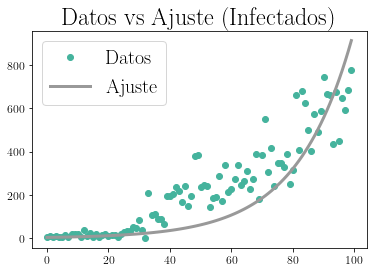

In [35]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Infectados)")
plt.plot(t,NIG.I[0:100],'o',label="Datos",color="#45B39D")
plt.plot(t,I,'-',lw=3,label="Ajuste")
plt.legend()

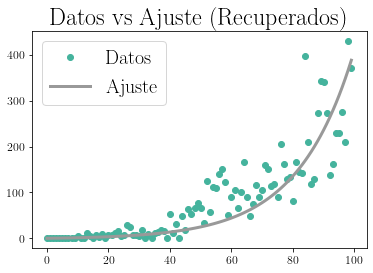

In [36]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Recuperados)")
plt.plot(t,NIG.R[0:100],'o',color="#45B39D",label="Datos")
plt.plot(t,R,'-',lw=3,label="Ajuste")
plt.legend()

In [37]:
N=106651922
def SFIL():   
    return N-2     # I_0
def IFIL():   
    return 2     # I_0
def RFIL():
    return 0       # R_0
FIL1=FIL.loc[:,["t","I","R"]]
FIL1=FIL1[0:100]

In [38]:
modeloFIL = pde.PDEmodel(FIL1, SIR, [SFIL,IFIL,RFIL], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [39]:
# Printing the initial condition
modeloFIL.initial_condition

array([106651920,         2,         0])

In [40]:
%%time
modeloFIL.fit()

    $\beta$  $\gamma$
0  0.078107  0.016644
Wall time: 967 ms


In [41]:
modeloFIL.best_params

,$\beta$,$\gamma$
0,0.078107,0.016644


In [42]:
modeloFIL.best_error

18060.493004838576

In [43]:
%%time
modeloFIL.likelihood_profiles()



Wall time: 1min 7s


In [44]:
modeloFIL.result_profiles

,parameter,value,error
0,$\beta$,0.000000,56154.926967
1,$\beta$,0.010101,55852.794747
2,$\beta$,0.020202,55786.488841
3,$\beta$,0.030303,51804.970433
4,$\beta$,0.040404,46020.784723
...,...,...,...
195,$\gamma$,0.959596,53710.825148
196,$\gamma$,0.969697,53721.315431
197,$\gamma$,0.979798,53731.547208
198,$\gamma$,0.989899,53741.878950


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


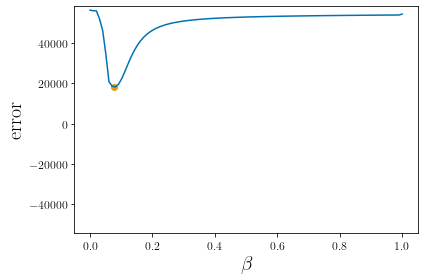

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


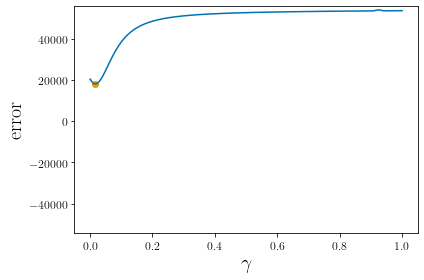

In [45]:
modeloFIL.plot_profiles()

In [46]:
# Tomamos los valores del modelo
beta = modeloFIL.best_params.iloc[0,0]
gamma = modeloFIL.best_params.iloc[0,1]
z0 = modeloFIL.initial_condition
# Integrate the SIR equations over the time grid, t.
t = FIL.t[0:100]
ret = odeint(SIR, z0, t, args=(beta, gamma))
S, I, R = ret.T

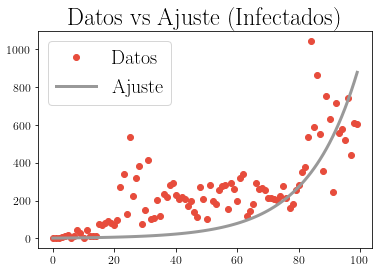

In [47]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Infectados)")
plt.plot(t,FIL.I[0:100],'o',color="#E74C3C",label="Datos")
plt.plot(t,I,'-',lw=3,label="Ajuste")
plt.legend()

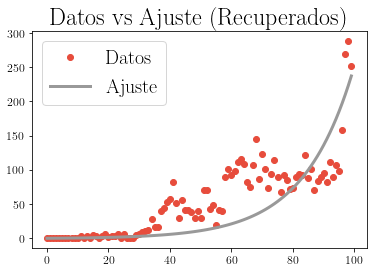

In [48]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Recuperados)")
plt.plot(t,FIL.R[0:100],'o',color="#E74C3C",label="Datos")
plt.plot(t,R,'-',lw=3,label="Ajuste")
plt.legend()

### 3.2 SIR-D

En el modelo anterior se considero a los Recuperados como aquellas personas que ya no se podían infectar, es decir personas que son inmunes temporalmente y a los muertos, pero ahora veremos que pasa si los consideramos por separado.

<style>
p.comment {
background-color: #FFFFFF;
padding: 10px;
border: 1px solid black;
margin-left: 25px;
border-radius: 5px;
font-style: italic;
}
</style>

<div class="alert alert-info">
    <ul>
      <li><strong>Susceptibles:</strong> personas que pueden contraer la enfermedad.</li>
      <li><strong>Infectados:</strong> personas que contrajeron la enfermedad y pueden contagiar a los demás.</li>
      <li><strong>Recuperados:</strong> personas que salieron de la enfermedad y adquieren inmunidad temporal.</li>
      <li><strong>Defunciones:</strong> personas que salieron de la enfermedad y murieron.</li>
    </ul>
</div>

$$
\begin{eqnarray}
\frac{dS}{dt}&=& -\beta S\frac{I}{N} \\
\frac{dI}{dt}&=& \beta S\frac{I}{N} - \gamma I - \epsilon D \\
\frac{dR}{dt}&=& \gamma I \\
\frac{dD}{dt}&=& \epsilon D 
\end{eqnarray}
$$


In [49]:
def SIRD(z, t, beta1, gamma1, epsilon1):
    
    S, I, R, D = z
    
    return [-beta1*(S/N)*I, beta1*(S/N)*I-gamma1*I-epsilon1*D, gamma1*I, epsilon1*D]

In [50]:
N=3449299
# Iniciales
def SUR1():
    return N-4   # S_0
def IUR1():   
    return 4     # I_0
def RUR1():
    return 0       # R_0
def DUR1():
    return 0       # D_0

In [51]:
modeloUR1 = pde.PDEmodel(URU, SIRD, [SUR1,IUR1,RUR1,DUR1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$\beta_1$', r'$\gamma_1$', r'$\epsilon_1$'], nvars=4, 
                         ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [52]:
# Printing the initial condition
modeloUR1.initial_condition

array([3449295,       4,       0,       0])

In [53]:
%%time
modeloUR1.fit()

   $\beta_1$  $\gamma_1$  $\epsilon_1$
0   0.027478    0.011274      0.179135
Wall time: 3.06 s


In [54]:
modeloUR1.best_params

,$\beta_1$,$\gamma_1$,$\epsilon_1$
0,0.027478,0.011274,0.179135


In [55]:
modeloUR1.best_error

3121.2081631564192

In [56]:
%%time
modeloUR1.likelihood_profiles()



Wall time: 11min 4s


In [57]:
modeloUR1.result_profiles

,parameter,value,error
0,$\beta_1$,0.000000,14720.445674
1,$\beta_1$,0.010101,14397.565895
2,$\beta_1$,0.020202,4806.163819
3,$\beta_1$,0.030303,3347.091936
4,$\beta_1$,0.040404,5951.184390
...,...,...,...
295,$\epsilon_1$,0.959596,3121.387537
296,$\epsilon_1$,0.969697,3121.153520
297,$\epsilon_1$,0.979798,3121.497406
298,$\epsilon_1$,0.989899,3121.313252


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


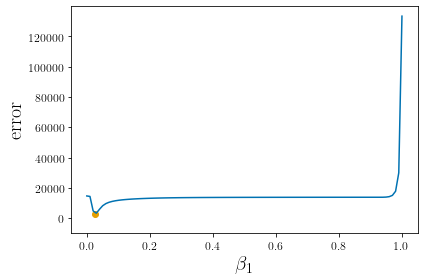

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


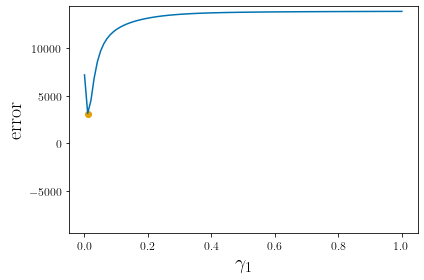

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


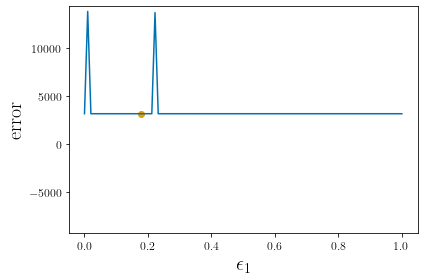

In [58]:
modeloUR1.plot_profiles()

In [59]:
# Tomamos los valores del modelo
beta1 = modeloUR1.best_params.iloc[0,0]
gamma1 = modeloUR1.best_params.iloc[0,1]
epsilon1 = modeloUR1.best_params.iloc[0,2]
z0 = modeloUR1.initial_condition
# Integrate the SIR equations over the time grid, t.
t = URU.t
ret = odeint(SIRD, z0, t, args=(beta1, gamma1, epsilon1))
S1, I1, R1, D1 = ret.T

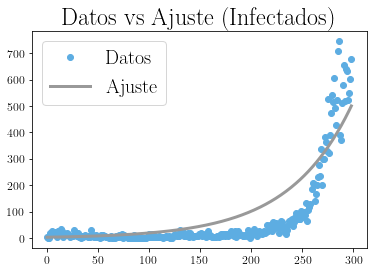

In [60]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Infectados)")
plt.plot(t,URU.I,'o',label="Datos",color="#5DADE2")
plt.plot(t,I1,'-',lw=3,label="Ajuste")
plt.legend()

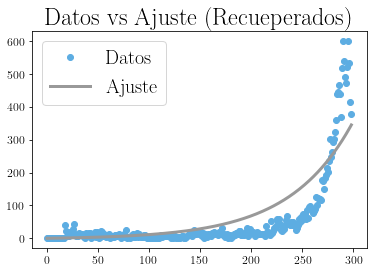

In [61]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Recueperados)")
plt.plot(t,URU.R,'o',label="Datos",color="#5DADE2")
plt.plot(t,R1,'-',lw=3,label="Ajuste")
plt.legend()

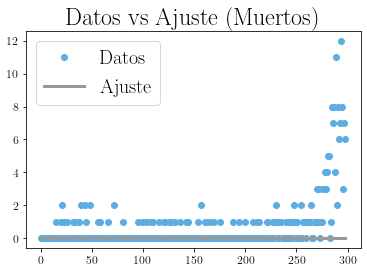

In [62]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Muertos)")
plt.plot(t,URU.D,'o',label="Datos",color="#5DADE2")
plt.plot(t,D1,'-',lw=3,label="Ajuste")
plt.legend()

In [63]:
N=195874740
# Iniciales
def SNI1():
    return N-4   # S_0
def INI1():   
    return 4     # I_0
def RNI1():
    return 0       # R_0
def DNI1():
    return 0       # D_0

In [64]:
modeloNI1 = pde.PDEmodel(NIG[0:100], SIRD, [SNI1,INI1,RNI1,DNI1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$\beta_1$', r'$\gamma_1$', r'$\epsilon_1$'], nvars=4, 
                         ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [65]:
# Printing the initial condition
modeloNI1.initial_condition

array([195874736,         4,         0,         0])

In [66]:
%%time
modeloNI1.fit()

   $\beta_1$  $\gamma_1$  $\epsilon_1$
0   0.078274    0.023412      0.519952
Wall time: 4.6 s


In [67]:
modeloNI1.best_params

,$\beta_1$,$\gamma_1$,$\epsilon_1$
0,0.078274,0.023412,0.519952


In [68]:
modeloNI1.best_error

6889.723937754522

In [69]:
%%time
modeloNI1.likelihood_profiles()



Wall time: 12min 23s


In [70]:
modeloNI1.result_profiles

,parameter,value,error
0,$\beta_1$,0.000000,40038.228055
1,$\beta_1$,0.010101,39601.223664
2,$\beta_1$,0.020202,38184.918955
3,$\beta_1$,0.030303,34127.120834
4,$\beta_1$,0.040404,26632.917955
...,...,...,...
295,$\epsilon_1$,0.959596,6889.764864
296,$\epsilon_1$,0.969697,6889.902251
297,$\epsilon_1$,0.979798,6889.733685
298,$\epsilon_1$,0.989899,6890.848925


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


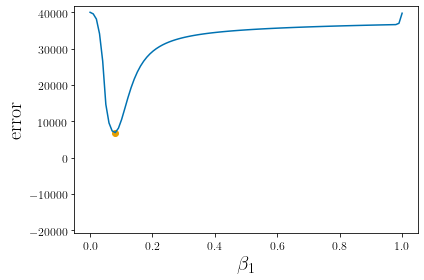

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


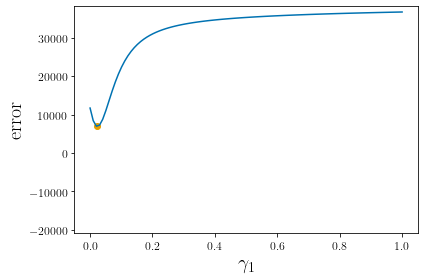

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


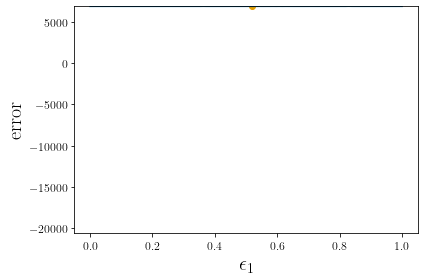

In [71]:
modeloNI1.plot_profiles()

In [72]:
# Tomamos los valores del modelo
beta1 = modeloNI1.best_params.iloc[0,0]
gamma1 = modeloNI1.best_params.iloc[0,1]
epsilon1 = modeloNI1.best_params.iloc[0,2]
z0 = modeloNI1.initial_condition
# Integrate the SIR equations over the time grid, t.
t = NIG.t[0:100]
ret = odeint(SIRD, z0, t, args=(beta1, gamma1,epsilon1))
S1, I1, R1, D1 = ret.T

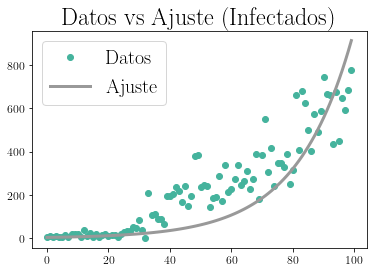

In [73]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Infectados)")
plt.plot(t,NIG.I[0:100],'o',label="Datos",color="#45B39D")
plt.plot(t,I1,'-',lw=3,label="Ajuste")
plt.legend()

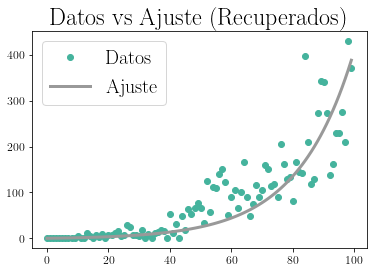

In [74]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Recuperados)")
plt.plot(t,NIG.R[0:100],'o',label="Datos",color="#45B39D")
plt.plot(t,R1,'-',lw=3,label="Ajuste")
plt.legend()

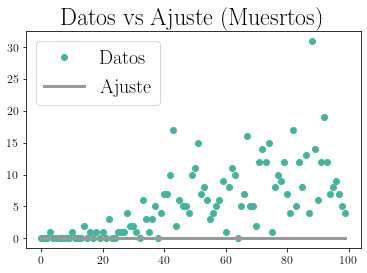

In [75]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Muesrtos)")
plt.plot(t,NIG.M[0:100],'o',label="Datos",color="#45B39D")
plt.plot(t,D1,'-',lw=3,label="Ajuste")
plt.legend()

In [76]:
N=106651922
# Iniciales
def SFI1():
    return N-2   # S_0
def IFI1():   
    return 2     # I_0
def RFI1():
    return 0       # R_0
def DFI1():
    return 0       # D_0

In [77]:
modeloFI1 = pde.PDEmodel(FIL[0:100], SIRD, [SFI1,IFI1,RFI1,DFI1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$\beta_1$', r'$\gamma_1$', r'$\epsilon_1$'], nvars=4, 
                         ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [78]:
# Printing the initial condition
modeloFI1.initial_condition

array([106651920,         2,         0,         0])

In [79]:
%%time
modeloFI1.fit()

   $\beta_1$  $\gamma_1$  $\epsilon_1$
0   0.078107    0.016644      0.337893
Wall time: 4.18 s


In [80]:
modeloFI1.best_params

,$\beta_1$,$\gamma_1$,$\epsilon_1$
0,0.078107,0.016644,0.337893


In [81]:
modeloFI1.best_error

12101.69866975271

In [82]:
%%time
modeloFI1.likelihood_profiles()



Wall time: 8min 56s


In [83]:
modeloFI1.result_profiles

,parameter,value,error
0,$\beta_1$,0.000000,37456.569157
1,$\beta_1$,0.010101,37336.269177
2,$\beta_1$,0.020202,37179.665002
3,$\beta_1$,0.030303,34579.823642
4,$\beta_1$,0.040404,30739.992628
...,...,...,...
295,$\epsilon_1$,0.959596,12102.104145
296,$\epsilon_1$,0.969697,12101.787165
297,$\epsilon_1$,0.979798,12102.405308
298,$\epsilon_1$,0.989899,12101.855072


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


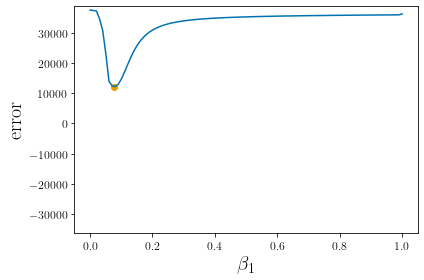

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


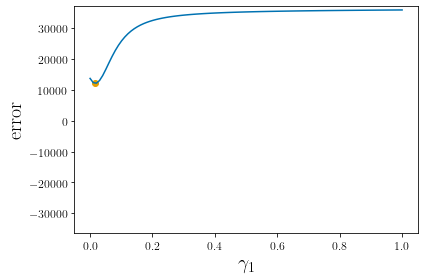

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


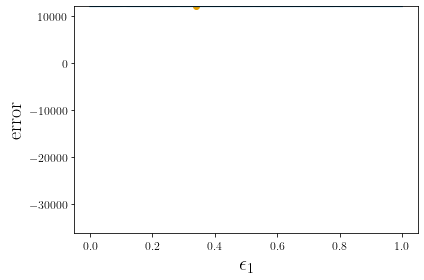

In [84]:
modeloFI1.plot_profiles()

In [85]:
# Tomamos los valores del modelo
beta1 = modeloFI1.best_params.iloc[0,0]
gamma1 = modeloFI1.best_params.iloc[0,1]
epsilon1 = modeloFI1.best_params.iloc[0,2]
z0 = modeloFI1.initial_condition
# Integrate the SIR equations over the time grid, t.
t = FIL.t[0:100]
ret = odeint(SIRD, z0, t, args=(beta1, gamma1, epsilon1))
S1, I1, R1, D1 = ret.T

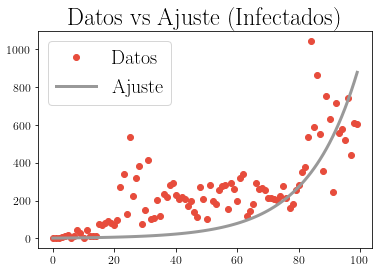

In [86]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Infectados)")
plt.plot(t,FIL.I[0:100],'o',color="#E74C3C",label="Datos")
plt.plot(t,I1,'-',lw=3,label="Ajuste")
plt.legend()

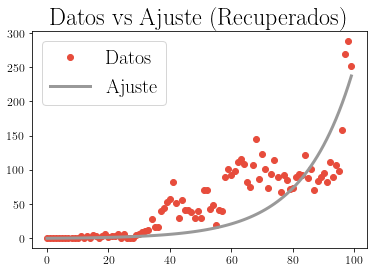

In [87]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Recuperados)")
plt.plot(t,FIL.R[0:100],'o',color="#E74C3C",label="Datos")
plt.plot(t,R1,'-',lw=3,label="Ajuste")
plt.legend()

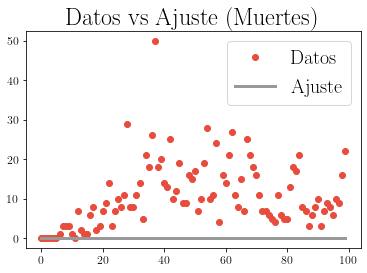

In [88]:
fig = plt.figure()
plt.title("Datos vs Ajuste (Muertes)")
plt.plot(t,FIL.D[0:100],'o',color="#E74C3C",label="Datos")
plt.plot(t,D1,'-',lw=3,label="Ajuste")
plt.legend()

## 4. Conclusiones

Ahora podemos comparar los 3 casos con sus tasas de contagio, tasas de recuperación y tasas de mortalidad durante los 100 días posteriores al primer contagio:

|Población | $\beta$ | $\gamma$ | $\frac{\beta}{\gamma}$ |
|------|-------|----|----|
| Uruguay  | 0.027434 |  0.011225    |  2.44401  |
| Nigeria  | 0.078274 |  0.023412    |  3.34333  |
| Filipinas | 0.078107 |  0.016645   |  4.69252  |


|Población | $\beta$ | $\gamma$ | $\frac{\beta}{\gamma}$ | $\epsilon$
|------|-------|----|----|----|
| Uruguay  | 0.027434  |  0.011225  |  2.444009  | 0.242546 |
| Nigeria  | 0.078274  |  0.023412  |  3.343328  | 0.271137 |
| Filipinas | 0.078107 |  0.016644  |  4.692802  | 0.697196 |

Como podemos ver, cada país tiene un comportamiento muy diferente debida a la forma en la que se manejó la pandemia, pues Uruguay ha tenido pocos contagios a largo del tiempo hasta el mes de noviembre que es donde ha empezado a crecer de forma exponencial, por esa razón es que pareciera ser menos contagiosa, de hecho se estima que una persona contagie a 2 dos personas y es la menos letal. 

El caso de Nigeria, podríamos categorizarlo en un caso estándar, pues la tasa de contagios es muy similar a la que se estimó en un principio por la $OMS$ (i.e. una persona contagia a 3 aproximadamente), además en este caso los contagios sí tuvieron  un comportamiento de ola, ya que se ve una elevación inicial con los primeros contagios y después una caida, hasta que comienza un rebrote o una segunda ola de contagios y por esta razón no podríamos modelar con todos los datos, solo el primer crecimiento.

Por último Filipinas tiene otra particularidad, primero podemos notar que parece ser más contagiosa la enfermedad (1 persona puede contagiar a casi 5 personas), así mismo, el comportamiento de sus contagios sólo ha seguido una ola de contagios, por lo que podríamos pensar que se ha logrado contener la enfermedad.

Por otra parte, entre el modelo $SIR$ y $SIR-D$ no hay cambios drásticos en la estimación de los parámetros $\alpha$ y $\beta$, pero sí nos da información adicional, ya que podemos ver la tasa de mortalidad, con estos resultados la enfermedad pareciera más mortal en Filipinas y menos mortal en Uruguay, pero esto lo debemos tomar con cierta reserva ya que los ajuste no resultan ser muy buenos.



## Referencias
Los datos fueron recopilados de https://covid19datahub.io/articles/data.html

